In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import zipfile

with zipfile.ZipFile('cat-and-dog.zip', 'r') as zip_ref:
    zip_ref.extractall('./cat-and-dog/')

In [3]:
!pip install torch torchvision torchaudio matplotlib numpy pillow scikit-learn seaborn tqdm

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 188.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 251.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 120.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 192.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 218.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 162.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 157.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 123.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 210.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset paths
TRAIN_PATH = "/root/cat-and-dog/training_set/training_set"
TEST_PATH = "/root/cat-and-dog/test_set/test_set"

# Dataset information
def analyze_dataset():
    """Analyze the dataset structure and sample distribution"""
    
    train_dataset = ImageFolder(root=TRAIN_PATH)
    test_dataset = ImageFolder(root=TEST_PATH)
    
    print("=" * 60)
    print("DATASET ANALYSIS")
    print("=" * 60)
    
    print(f"Classes: {train_dataset.classes}")
    print(f"Class to index mapping: {train_dataset.class_to_idx}")
    
    # Count samples per class
    train_counts = {}
    test_counts = {}
    
    for class_name in train_dataset.classes:
        train_class_path = os.path.join(TRAIN_PATH, class_name)
        test_class_path = os.path.join(TEST_PATH, class_name)
        
        train_counts[class_name] = len([f for f in os.listdir(train_class_path) 
                                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        test_counts[class_name] = len([f for f in os.listdir(test_class_path) 
                                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"\nTraining set:")
    for class_name, count in train_counts.items():
        print(f"  {class_name}: {count} images")
    
    print(f"\nTest set:")
    for class_name, count in test_counts.items():
        print(f"  {class_name}: {count} images")
    
    print(f"\nTotal training images: {sum(train_counts.values())}")
    print(f"Total test images: {sum(test_counts.values())}")
    
    return train_counts, test_counts

# Run dataset analysis
train_counts, test_counts = analyze_dataset()

Using device: cuda
DATASET ANALYSIS
Classes: ['cats', 'dogs']
Class to index mapping: {'cats': 0, 'dogs': 1}

Training set:
  cats: 4000 images
  dogs: 4005 images

Test set:
  cats: 1011 images
  dogs: 1012 images

Total training images: 8005
Total test images: 2023


In [12]:
class CatDogCNN(nn.Module):
    """Advanced CNN for Cat vs Dog Classification"""
    
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(CatDogCNN, self).__init__()
        
        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(0.25)
        )
        
        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(0.25)
        )
        
        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(0.25)
        )
        
        # Fourth convolutional block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout2d(0.25)
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            # nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            # nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            # nn.Dropout(dropout_rate/2),
            nn.Linear(64, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights using Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, verbose=False):
        """Forward pass with optional shape printing"""
        if verbose:
            print(f"Input shape: {x.shape}")
        
        x = self.conv_block1(x)
        if verbose:
            print(f"After conv_block1: {x.shape}")
        
        x = self.conv_block2(x)
        if verbose:
            print(f"After conv_block2: {x.shape}")
        
        x = self.conv_block3(x)
        if verbose:
            print(f"After conv_block3: {x.shape}")
        
        x = self.conv_block4(x)
        if verbose:
            print(f"After conv_block4: {x.shape}")
        
        x = self.global_avg_pool(x)
        if verbose:
            print(f"After global_avg_pool: {x.shape}")
        
        x = x.view(x.size(0), -1)
        if verbose:
            print(f"After flatten: {x.shape}")
        
        x = self.classifier(x)
        if verbose:
            print(f"Final output: {x.shape}")
        
        return x

def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def model_summary(model, input_size=(10, 3, 112, 112)):
    """Print detailed model summary"""
    print("=" * 80)
    print("MODEL SUMMARY")
    print("=" * 80)
    
    total_params, trainable_params = count_parameters(model)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    
    # Test forward pass
    dummy_input = torch.randn(input_size).to(device)
    print(f"\nForward pass test with input shape: {input_size}")
    print("-" * 50)
    
    with torch.no_grad():
        output = model(dummy_input, verbose=True)
    
    print("=" * 80)

# Create and analyze model
model = CatDogCNN(num_classes=2).to(device)
model_summary(model)

MODEL SUMMARY
Total parameters: 1,215,458
Trainable parameters: 1,215,458
Non-trainable parameters: 0

Forward pass test with input shape: (10, 3, 112, 112)
--------------------------------------------------
Input shape: torch.Size([10, 3, 112, 112])
After conv_block1: torch.Size([10, 32, 56, 56])
After conv_block2: torch.Size([10, 64, 28, 28])
After conv_block3: torch.Size([10, 128, 14, 14])
After conv_block4: torch.Size([10, 256, 7, 7])
After global_avg_pool: torch.Size([10, 256, 1, 1])
After flatten: torch.Size([10, 256])
Final output: torch.Size([10, 2])


Loading datasets...
Classes: ['cats', 'dogs']


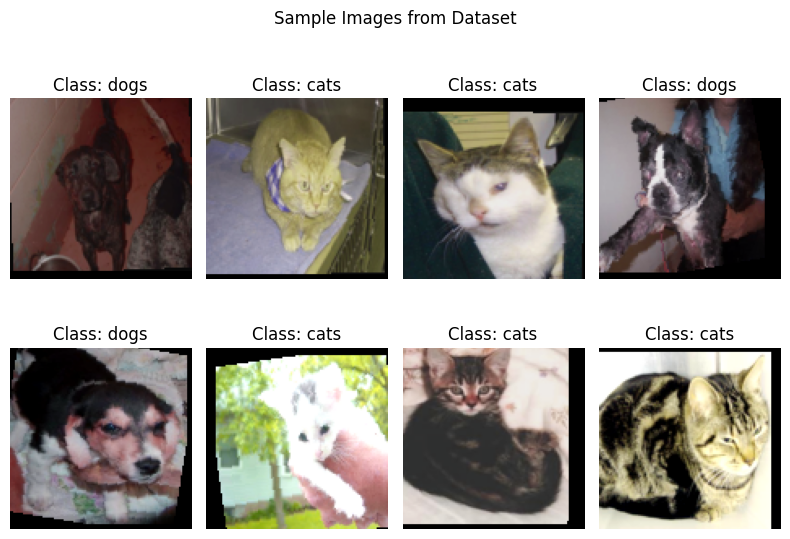


Starting model training...
Starting training...


Epoch 1/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 16.52it/s, Loss=0.5827, Acc=63.09%]



Epoch [1/100] - Time: 6.66s
Train Loss: 0.6533, Train Acc: 61.10%
Val Loss: 0.6432, Val Acc: 63.09%
Learning Rate: 0.000043
------------------------------------------------------------
New best validation accuracy: 63.09% - Model saved!


Epoch 2/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.4743, Acc=68.77%]



Epoch [2/100] - Time: 6.50s
Train Loss: 0.6166, Train Acc: 65.12%
Val Loss: 0.5953, Val Acc: 68.77%
Learning Rate: 0.000050
------------------------------------------------------------
New best validation accuracy: 68.77% - Model saved!


Epoch 3/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.6191, Acc=66.71%]



Epoch [3/100] - Time: 6.50s
Train Loss: 0.6045, Train Acc: 67.85%
Val Loss: 0.6005, Val Acc: 66.71%
Learning Rate: 0.000064
------------------------------------------------------------


Epoch 4/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 17.95it/s, Loss=0.7284, Acc=60.71%]



Epoch [4/100] - Time: 6.57s
Train Loss: 0.5799, Train Acc: 69.49%
Val Loss: 0.7177, Val Acc: 60.71%
Learning Rate: 0.000082
------------------------------------------------------------


Epoch 5/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.52it/s, Loss=0.5164, Acc=71.39%]



Epoch [5/100] - Time: 6.58s
Train Loss: 0.5612, Train Acc: 70.24%
Val Loss: 0.5501, Val Acc: 71.39%
Learning Rate: 0.000104
------------------------------------------------------------
New best validation accuracy: 71.39% - Model saved!


Epoch 6/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.6505, Acc=73.02%]



Epoch [6/100] - Time: 6.57s
Train Loss: 0.5574, Train Acc: 71.36%
Val Loss: 0.5474, Val Acc: 73.02%
Learning Rate: 0.000132
------------------------------------------------------------
New best validation accuracy: 73.02% - Model saved!


Epoch 7/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.39it/s, Loss=0.4716, Acc=72.89%]



Epoch [7/100] - Time: 6.58s
Train Loss: 0.5357, Train Acc: 73.13%
Val Loss: 0.5419, Val Acc: 72.89%
Learning Rate: 0.000163
------------------------------------------------------------


Epoch 8/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.50it/s, Loss=0.2424, Acc=73.02%]



Epoch [8/100] - Time: 6.56s
Train Loss: 0.5183, Train Acc: 73.75%
Val Loss: 0.5305, Val Acc: 73.02%
Learning Rate: 0.000199
------------------------------------------------------------


Epoch 9/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.52it/s, Loss=1.4921, Acc=70.96%]



Epoch [9/100] - Time: 6.51s
Train Loss: 0.5165, Train Acc: 73.80%
Val Loss: 0.6279, Val Acc: 70.96%
Learning Rate: 0.000238
------------------------------------------------------------


Epoch 10/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.45it/s, Loss=1.0675, Acc=75.08%]



Epoch [10/100] - Time: 6.52s
Train Loss: 0.5027, Train Acc: 74.75%
Val Loss: 0.5193, Val Acc: 75.08%
Learning Rate: 0.000280
------------------------------------------------------------
New best validation accuracy: 75.08% - Model saved!


Epoch 11/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s, Loss=0.3152, Acc=66.46%]



Epoch [11/100] - Time: 6.62s
Train Loss: 0.4752, Train Acc: 77.05%
Val Loss: 0.7874, Val Acc: 66.46%
Learning Rate: 0.000325
------------------------------------------------------------


Epoch 12/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.1296, Acc=70.39%]



Epoch [12/100] - Time: 6.64s
Train Loss: 0.4617, Train Acc: 78.08%
Val Loss: 0.5875, Val Acc: 70.39%
Learning Rate: 0.000372
------------------------------------------------------------


Epoch 13/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s, Loss=0.1165, Acc=81.14%]



Epoch [13/100] - Time: 6.59s
Train Loss: 0.4356, Train Acc: 79.00%
Val Loss: 0.4150, Val Acc: 81.14%
Learning Rate: 0.000420
------------------------------------------------------------
New best validation accuracy: 81.14% - Model saved!


Epoch 14/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s, Loss=0.0600, Acc=77.70%]



Epoch [14/100] - Time: 6.56s
Train Loss: 0.4227, Train Acc: 80.56%
Val Loss: 0.4836, Val Acc: 77.70%
Learning Rate: 0.000470
------------------------------------------------------------


Epoch 15/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.42it/s, Loss=0.1464, Acc=77.51%]



Epoch [15/100] - Time: 6.56s
Train Loss: 0.4171, Train Acc: 80.72%
Val Loss: 0.4647, Val Acc: 77.51%
Learning Rate: 0.000520
------------------------------------------------------------


Epoch 16/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.36it/s, Loss=0.1148, Acc=82.26%]



Epoch [16/100] - Time: 6.62s
Train Loss: 0.3926, Train Acc: 82.25%
Val Loss: 0.3727, Val Acc: 82.26%
Learning Rate: 0.000570
------------------------------------------------------------
New best validation accuracy: 82.26% - Model saved!


Epoch 17/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.36it/s, Loss=0.0511, Acc=81.01%]



Epoch [17/100] - Time: 6.55s
Train Loss: 0.3747, Train Acc: 83.18%
Val Loss: 0.4018, Val Acc: 81.01%
Learning Rate: 0.000620
------------------------------------------------------------


Epoch 18/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.39it/s, Loss=0.1080, Acc=79.76%]



Epoch [18/100] - Time: 6.60s
Train Loss: 0.3606, Train Acc: 83.82%
Val Loss: 0.4432, Val Acc: 79.76%
Learning Rate: 0.000669
------------------------------------------------------------


Epoch 19/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.30it/s, Loss=3.5749, Acc=58.71%]



Epoch [19/100] - Time: 6.61s
Train Loss: 0.3472, Train Acc: 84.49%
Val Loss: 1.1735, Val Acc: 58.71%
Learning Rate: 0.000716
------------------------------------------------------------


Epoch 20/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.6642, Acc=85.38%]



Epoch [20/100] - Time: 6.58s
Train Loss: 0.3362, Train Acc: 85.79%
Val Loss: 0.3486, Val Acc: 85.38%
Learning Rate: 0.000760
------------------------------------------------------------
New best validation accuracy: 85.38% - Model saved!


Epoch 21/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.41it/s, Loss=0.0896, Acc=87.20%]



Epoch [21/100] - Time: 6.55s
Train Loss: 0.3121, Train Acc: 86.31%
Val Loss: 0.2960, Val Acc: 87.20%
Learning Rate: 0.000802
------------------------------------------------------------
New best validation accuracy: 87.20% - Model saved!


Epoch 22/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.22it/s, Loss=1.7577, Acc=62.09%]



Epoch [22/100] - Time: 6.56s
Train Loss: 0.2870, Train Acc: 87.84%
Val Loss: 0.8955, Val Acc: 62.09%
Learning Rate: 0.000841
------------------------------------------------------------


Epoch 23/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.41it/s, Loss=0.2700, Acc=83.39%]



Epoch [23/100] - Time: 6.57s
Train Loss: 0.2761, Train Acc: 88.34%
Val Loss: 0.3887, Val Acc: 83.39%
Learning Rate: 0.000877
------------------------------------------------------------


Epoch 24/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s, Loss=0.0626, Acc=80.14%]



Epoch [24/100] - Time: 6.55s
Train Loss: 0.2845, Train Acc: 88.09%
Val Loss: 0.4652, Val Acc: 80.14%
Learning Rate: 0.000909
------------------------------------------------------------


Epoch 25/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.36it/s, Loss=0.2223, Acc=86.13%]



Epoch [25/100] - Time: 6.59s
Train Loss: 0.2735, Train Acc: 88.12%
Val Loss: 0.3266, Val Acc: 86.13%
Learning Rate: 0.000936
------------------------------------------------------------


Epoch 26/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0223, Acc=73.08%]



Epoch [26/100] - Time: 6.60s
Train Loss: 0.2510, Train Acc: 89.43%
Val Loss: 0.5756, Val Acc: 73.08%
Learning Rate: 0.000959
------------------------------------------------------------


Epoch 27/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.54it/s, Loss=1.2911, Acc=86.57%]



Epoch [27/100] - Time: 6.56s
Train Loss: 0.2553, Train Acc: 89.55%
Val Loss: 0.3523, Val Acc: 86.57%
Learning Rate: 0.000977
------------------------------------------------------------


Epoch 28/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.28it/s, Loss=0.0018, Acc=60.09%]



Epoch [28/100] - Time: 6.63s
Train Loss: 0.2509, Train Acc: 89.91%
Val Loss: 1.3934, Val Acc: 60.09%
Learning Rate: 0.000990
------------------------------------------------------------


Epoch 29/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.32it/s, Loss=0.3990, Acc=86.20%]



Epoch [29/100] - Time: 6.60s
Train Loss: 0.2462, Train Acc: 89.76%
Val Loss: 0.3327, Val Acc: 86.20%
Learning Rate: 0.000997
------------------------------------------------------------


Epoch 30/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.36it/s, Loss=0.0441, Acc=88.94%]



Epoch [30/100] - Time: 6.52s
Train Loss: 0.2382, Train Acc: 90.13%
Val Loss: 0.2574, Val Acc: 88.94%
Learning Rate: 0.001000
------------------------------------------------------------
New best validation accuracy: 88.94% - Model saved!


Epoch 31/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.0040, Acc=79.76%]



Epoch [31/100] - Time: 6.61s
Train Loss: 0.1981, Train Acc: 92.02%
Val Loss: 0.5008, Val Acc: 79.76%
Learning Rate: 0.000999
------------------------------------------------------------


Epoch 32/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0029, Acc=85.70%]



Epoch [32/100] - Time: 6.56s
Train Loss: 0.1953, Train Acc: 91.97%
Val Loss: 0.3431, Val Acc: 85.70%
Learning Rate: 0.000998
------------------------------------------------------------


Epoch 33/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.0107, Acc=85.70%]



Epoch [33/100] - Time: 6.54s
Train Loss: 0.1989, Train Acc: 91.76%
Val Loss: 0.3339, Val Acc: 85.70%
Learning Rate: 0.000995
------------------------------------------------------------


Epoch 34/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.45it/s, Loss=0.0460, Acc=88.51%]



Epoch [34/100] - Time: 6.53s
Train Loss: 0.1895, Train Acc: 91.55%
Val Loss: 0.2696, Val Acc: 88.51%
Learning Rate: 0.000992
------------------------------------------------------------


Epoch 35/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.3351, Acc=86.63%]



Epoch [35/100] - Time: 6.52s
Train Loss: 0.1833, Train Acc: 92.82%
Val Loss: 0.3190, Val Acc: 86.63%
Learning Rate: 0.000987
------------------------------------------------------------


Epoch 36/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.51it/s, Loss=0.0154, Acc=91.38%]



Epoch [36/100] - Time: 6.58s
Train Loss: 0.1887, Train Acc: 92.18%
Val Loss: 0.2058, Val Acc: 91.38%
Learning Rate: 0.000982
------------------------------------------------------------
New best validation accuracy: 91.38% - Model saved!


Epoch 37/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.1209, Acc=90.63%]



Epoch [37/100] - Time: 6.55s
Train Loss: 0.1614, Train Acc: 93.39%
Val Loss: 0.2247, Val Acc: 90.63%
Learning Rate: 0.000975
------------------------------------------------------------


Epoch 38/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.0742, Acc=85.88%]



Epoch [38/100] - Time: 6.59s
Train Loss: 0.1605, Train Acc: 93.83%
Val Loss: 0.3409, Val Acc: 85.88%
Learning Rate: 0.000968
------------------------------------------------------------


Epoch 39/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.37it/s, Loss=0.0294, Acc=88.69%]



Epoch [39/100] - Time: 6.61s
Train Loss: 0.2129, Train Acc: 90.93%
Val Loss: 0.2612, Val Acc: 88.69%
Learning Rate: 0.000960
------------------------------------------------------------


Epoch 40/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.41it/s, Loss=0.0039, Acc=91.19%]



Epoch [40/100] - Time: 6.59s
Train Loss: 0.1786, Train Acc: 92.75%
Val Loss: 0.2097, Val Acc: 91.19%
Learning Rate: 0.000950
------------------------------------------------------------


Epoch 41/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.37it/s, Loss=0.0061, Acc=90.57%]



Epoch [41/100] - Time: 6.62s
Train Loss: 0.1527, Train Acc: 93.94%
Val Loss: 0.2278, Val Acc: 90.57%
Learning Rate: 0.000940
------------------------------------------------------------


Epoch 42/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.33it/s, Loss=0.0016, Acc=89.13%]



Epoch [42/100] - Time: 6.54s
Train Loss: 0.1575, Train Acc: 93.94%
Val Loss: 0.2672, Val Acc: 89.13%
Learning Rate: 0.000929
------------------------------------------------------------


Epoch 43/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.33it/s, Loss=0.0292, Acc=91.88%]



Epoch [43/100] - Time: 6.56s
Train Loss: 0.1561, Train Acc: 93.63%
Val Loss: 0.1909, Val Acc: 91.88%
Learning Rate: 0.000917
------------------------------------------------------------
New best validation accuracy: 91.88% - Model saved!


Epoch 44/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.31it/s, Loss=0.0456, Acc=88.19%]



Epoch [44/100] - Time: 6.61s
Train Loss: 0.1733, Train Acc: 93.25%
Val Loss: 0.2843, Val Acc: 88.19%
Learning Rate: 0.000904
------------------------------------------------------------


Epoch 45/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.28it/s, Loss=0.0005, Acc=76.33%]



Epoch [45/100] - Time: 6.62s
Train Loss: 0.1838, Train Acc: 93.07%
Val Loss: 0.6760, Val Acc: 76.33%
Learning Rate: 0.000891
------------------------------------------------------------


Epoch 46/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.0144, Acc=91.26%]



Epoch [46/100] - Time: 6.58s
Train Loss: 0.1825, Train Acc: 92.88%
Val Loss: 0.2084, Val Acc: 91.26%
Learning Rate: 0.000876
------------------------------------------------------------


Epoch 47/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.41it/s, Loss=0.0136, Acc=92.57%]



Epoch [47/100] - Time: 6.57s
Train Loss: 0.1324, Train Acc: 94.52%
Val Loss: 0.1931, Val Acc: 92.57%
Learning Rate: 0.000861
------------------------------------------------------------
New best validation accuracy: 92.57% - Model saved!


Epoch 48/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.14it/s, Loss=0.0050, Acc=69.21%]



Epoch [48/100] - Time: 6.56s
Train Loss: 0.1292, Train Acc: 95.28%
Val Loss: 1.1387, Val Acc: 69.21%
Learning Rate: 0.000845
------------------------------------------------------------


Epoch 49/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.0107, Acc=90.88%]



Epoch [49/100] - Time: 6.60s
Train Loss: 0.1595, Train Acc: 93.74%
Val Loss: 0.2066, Val Acc: 90.88%
Learning Rate: 0.000829
------------------------------------------------------------


Epoch 50/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.37it/s, Loss=0.0712, Acc=93.00%]



Epoch [50/100] - Time: 6.58s
Train Loss: 0.1742, Train Acc: 92.72%
Val Loss: 0.1658, Val Acc: 93.00%
Learning Rate: 0.000812
------------------------------------------------------------
New best validation accuracy: 93.00% - Model saved!


Epoch 51/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.27it/s, Loss=0.0114, Acc=91.69%]



Epoch [51/100] - Time: 6.56s
Train Loss: 0.1309, Train Acc: 94.99%
Val Loss: 0.1978, Val Acc: 91.69%
Learning Rate: 0.000794
------------------------------------------------------------


Epoch 52/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.38it/s, Loss=0.0011, Acc=92.63%]



Epoch [52/100] - Time: 6.59s
Train Loss: 0.1437, Train Acc: 94.33%
Val Loss: 0.1692, Val Acc: 92.63%
Learning Rate: 0.000775
------------------------------------------------------------


Epoch 53/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0221, Acc=89.32%]



Epoch [53/100] - Time: 6.55s
Train Loss: 0.1228, Train Acc: 95.57%
Val Loss: 0.3011, Val Acc: 89.32%
Learning Rate: 0.000756
------------------------------------------------------------


Epoch 54/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s, Loss=0.0223, Acc=86.32%]



Epoch [54/100] - Time: 6.56s
Train Loss: 0.1427, Train Acc: 94.32%
Val Loss: 0.3315, Val Acc: 86.32%
Learning Rate: 0.000737
------------------------------------------------------------


Epoch 55/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.0035, Acc=92.63%]



Epoch [55/100] - Time: 6.57s
Train Loss: 0.1651, Train Acc: 93.97%
Val Loss: 0.1818, Val Acc: 92.63%
Learning Rate: 0.000717
------------------------------------------------------------


Epoch 56/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.50it/s, Loss=0.0064, Acc=90.69%]



Epoch [56/100] - Time: 6.56s
Train Loss: 0.1014, Train Acc: 96.14%
Val Loss: 0.2348, Val Acc: 90.69%
Learning Rate: 0.000696
------------------------------------------------------------


Epoch 57/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.0258, Acc=91.57%]



Epoch [57/100] - Time: 6.60s
Train Loss: 0.1152, Train Acc: 95.14%
Val Loss: 0.2197, Val Acc: 91.57%
Learning Rate: 0.000675
------------------------------------------------------------


Epoch 58/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.0019, Acc=92.00%]



Epoch [58/100] - Time: 6.61s
Train Loss: 0.0962, Train Acc: 96.50%
Val Loss: 0.2140, Val Acc: 92.00%
Learning Rate: 0.000654
------------------------------------------------------------


Epoch 59/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0035, Acc=89.13%]



Epoch [59/100] - Time: 6.59s
Train Loss: 0.1107, Train Acc: 95.57%
Val Loss: 0.2926, Val Acc: 89.13%
Learning Rate: 0.000633
------------------------------------------------------------


Epoch 60/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.0001, Acc=87.26%]



Epoch [60/100] - Time: 6.57s
Train Loss: 0.0941, Train Acc: 96.47%
Val Loss: 0.3613, Val Acc: 87.26%
Learning Rate: 0.000611
------------------------------------------------------------


Epoch 61/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0031, Acc=84.57%]



Epoch [61/100] - Time: 6.55s
Train Loss: 0.0805, Train Acc: 96.83%
Val Loss: 0.5749, Val Acc: 84.57%
Learning Rate: 0.000589
------------------------------------------------------------


Epoch 62/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.51it/s, Loss=0.0032, Acc=93.07%]



Epoch [62/100] - Time: 6.58s
Train Loss: 0.0858, Train Acc: 96.75%
Val Loss: 0.1808, Val Acc: 93.07%
Learning Rate: 0.000567
------------------------------------------------------------
New best validation accuracy: 93.07% - Model saved!


Epoch 63/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s, Loss=0.0007, Acc=93.50%]



Epoch [63/100] - Time: 6.58s
Train Loss: 0.0814, Train Acc: 96.69%
Val Loss: 0.1673, Val Acc: 93.50%
Learning Rate: 0.000545
------------------------------------------------------------
New best validation accuracy: 93.50% - Model saved!


Epoch 64/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0003, Acc=89.44%]



Epoch [64/100] - Time: 6.61s
Train Loss: 0.0915, Train Acc: 96.64%
Val Loss: 0.2792, Val Acc: 89.44%
Learning Rate: 0.000522
------------------------------------------------------------


Epoch 65/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s, Loss=0.0002, Acc=93.69%]



Epoch [65/100] - Time: 6.60s
Train Loss: 0.1074, Train Acc: 95.63%
Val Loss: 0.1507, Val Acc: 93.69%
Learning Rate: 0.000500
------------------------------------------------------------
New best validation accuracy: 93.69% - Model saved!


Epoch 66/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.44it/s, Loss=0.0074, Acc=92.25%]



Epoch [66/100] - Time: 6.56s
Train Loss: 0.0765, Train Acc: 96.99%
Val Loss: 0.2199, Val Acc: 92.25%
Learning Rate: 0.000477
------------------------------------------------------------


Epoch 67/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0006, Acc=91.57%]



Epoch [67/100] - Time: 6.61s
Train Loss: 0.1458, Train Acc: 94.41%
Val Loss: 0.2012, Val Acc: 91.57%
Learning Rate: 0.000455
------------------------------------------------------------


Epoch 68/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.0007, Acc=93.13%]



Epoch [68/100] - Time: 6.63s
Train Loss: 0.0883, Train Acc: 96.69%
Val Loss: 0.1630, Val Acc: 93.13%
Learning Rate: 0.000433
------------------------------------------------------------


Epoch 69/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.42it/s, Loss=0.0010, Acc=94.13%]



Epoch [69/100] - Time: 6.60s
Train Loss: 0.0786, Train Acc: 96.74%
Val Loss: 0.1535, Val Acc: 94.13%
Learning Rate: 0.000411
------------------------------------------------------------
New best validation accuracy: 94.13% - Model saved!


Epoch 70/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.0002, Acc=93.32%]



Epoch [70/100] - Time: 6.60s
Train Loss: 0.0565, Train Acc: 97.78%
Val Loss: 0.1782, Val Acc: 93.32%
Learning Rate: 0.000389
------------------------------------------------------------


Epoch 71/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.52it/s, Loss=0.0007, Acc=94.63%]



Epoch [71/100] - Time: 6.57s
Train Loss: 0.0585, Train Acc: 97.77%
Val Loss: 0.1380, Val Acc: 94.63%
Learning Rate: 0.000367
------------------------------------------------------------
New best validation accuracy: 94.63% - Model saved!


Epoch 72/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.50it/s, Loss=0.0001, Acc=93.19%]



Epoch [72/100] - Time: 6.55s
Train Loss: 0.0511, Train Acc: 98.17%
Val Loss: 0.1780, Val Acc: 93.19%
Learning Rate: 0.000345
------------------------------------------------------------


Epoch 73/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0001, Acc=94.32%]



Epoch [73/100] - Time: 6.54s
Train Loss: 0.0596, Train Acc: 97.53%
Val Loss: 0.1680, Val Acc: 94.32%
Learning Rate: 0.000324
------------------------------------------------------------


Epoch 74/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.35it/s, Loss=0.0000, Acc=94.25%]



Epoch [74/100] - Time: 6.64s
Train Loss: 0.0777, Train Acc: 97.99%
Val Loss: 0.1687, Val Acc: 94.25%
Learning Rate: 0.000303
------------------------------------------------------------


Epoch 75/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.37it/s, Loss=0.0003, Acc=92.63%]



Epoch [75/100] - Time: 6.62s
Train Loss: 0.0912, Train Acc: 96.39%
Val Loss: 0.1974, Val Acc: 92.63%
Learning Rate: 0.000283
------------------------------------------------------------


Epoch 76/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.44it/s, Loss=0.0004, Acc=93.82%]



Epoch [76/100] - Time: 6.56s
Train Loss: 0.0544, Train Acc: 97.92%
Val Loss: 0.1524, Val Acc: 93.82%
Learning Rate: 0.000263
------------------------------------------------------------


Epoch 77/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.45it/s, Loss=0.0000, Acc=93.63%]



Epoch [77/100] - Time: 6.53s
Train Loss: 0.0368, Train Acc: 98.77%
Val Loss: 0.1910, Val Acc: 93.63%
Learning Rate: 0.000243
------------------------------------------------------------


Epoch 78/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.0002, Acc=94.19%]



Epoch [78/100] - Time: 6.57s
Train Loss: 0.0390, Train Acc: 98.70%
Val Loss: 0.1737, Val Acc: 94.19%
Learning Rate: 0.000224
------------------------------------------------------------


Epoch 79/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.0001, Acc=95.07%]



Epoch [79/100] - Time: 6.58s
Train Loss: 0.0339, Train Acc: 98.81%
Val Loss: 0.1551, Val Acc: 95.07%
Learning Rate: 0.000206
------------------------------------------------------------
New best validation accuracy: 95.07% - Model saved!


Epoch 80/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0001, Acc=94.38%]



Epoch [80/100] - Time: 6.55s
Train Loss: 0.0298, Train Acc: 98.84%
Val Loss: 0.1980, Val Acc: 94.38%
Learning Rate: 0.000188
------------------------------------------------------------


Epoch 81/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0001, Acc=94.44%]



Epoch [81/100] - Time: 6.52s
Train Loss: 0.0395, Train Acc: 98.78%
Val Loss: 0.1969, Val Acc: 94.44%
Learning Rate: 0.000171
------------------------------------------------------------


Epoch 82/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.35it/s, Loss=0.0000, Acc=91.63%]



Epoch [82/100] - Time: 6.60s
Train Loss: 0.0390, Train Acc: 98.50%
Val Loss: 0.2785, Val Acc: 91.63%
Learning Rate: 0.000154
------------------------------------------------------------


Epoch 83/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.0000, Acc=94.57%]



Epoch [83/100] - Time: 6.58s
Train Loss: 0.0368, Train Acc: 98.81%
Val Loss: 0.1819, Val Acc: 94.57%
Learning Rate: 0.000138
------------------------------------------------------------


Epoch 84/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.21it/s, Loss=0.0001, Acc=94.57%]



Epoch [84/100] - Time: 6.56s
Train Loss: 0.0337, Train Acc: 98.77%
Val Loss: 0.1644, Val Acc: 94.57%
Learning Rate: 0.000123
------------------------------------------------------------


Epoch 85/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.31it/s, Loss=0.0000, Acc=95.13%]



Epoch [85/100] - Time: 6.59s
Train Loss: 0.0257, Train Acc: 99.03%
Val Loss: 0.1614, Val Acc: 95.13%
Learning Rate: 0.000109
------------------------------------------------------------
New best validation accuracy: 95.13% - Model saved!


Epoch 86/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.49it/s, Loss=0.0000, Acc=94.44%]



Epoch [86/100] - Time: 6.57s
Train Loss: 0.0202, Train Acc: 99.31%
Val Loss: 0.1901, Val Acc: 94.44%
Learning Rate: 0.000095
------------------------------------------------------------


Epoch 87/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s, Loss=0.0000, Acc=94.50%]



Epoch [87/100] - Time: 6.59s
Train Loss: 0.0384, Train Acc: 99.14%
Val Loss: 0.1869, Val Acc: 94.50%
Learning Rate: 0.000083
------------------------------------------------------------


Epoch 88/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.44it/s, Loss=0.0000, Acc=94.50%]



Epoch [88/100] - Time: 6.57s
Train Loss: 0.0359, Train Acc: 98.78%
Val Loss: 0.1717, Val Acc: 94.50%
Learning Rate: 0.000071
------------------------------------------------------------


Epoch 89/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s, Loss=0.0001, Acc=94.75%]



Epoch [89/100] - Time: 6.60s
Train Loss: 0.0388, Train Acc: 99.25%
Val Loss: 0.1795, Val Acc: 94.75%
Learning Rate: 0.000060
------------------------------------------------------------


Epoch 90/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.0000, Acc=94.57%]



Epoch [90/100] - Time: 6.59s
Train Loss: 0.0175, Train Acc: 99.38%
Val Loss: 0.1806, Val Acc: 94.57%
Learning Rate: 0.000049
------------------------------------------------------------


Epoch 91/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.53it/s, Loss=0.0000, Acc=94.88%]



Epoch [91/100] - Time: 6.55s
Train Loss: 0.0213, Train Acc: 99.28%
Val Loss: 0.1825, Val Acc: 94.88%
Learning Rate: 0.000040
------------------------------------------------------------


Epoch 92/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s, Loss=0.0000, Acc=94.38%]



Epoch [92/100] - Time: 6.60s
Train Loss: 0.0237, Train Acc: 99.08%
Val Loss: 0.1677, Val Acc: 94.38%
Learning Rate: 0.000032
------------------------------------------------------------


Epoch 93/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s, Loss=0.0000, Acc=95.19%]



Epoch [93/100] - Time: 6.57s
Train Loss: 0.0376, Train Acc: 99.23%
Val Loss: 0.1692, Val Acc: 95.19%
Learning Rate: 0.000024
------------------------------------------------------------
New best validation accuracy: 95.19% - Model saved!


Epoch 94/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.39it/s, Loss=0.0000, Acc=94.75%]



Epoch [94/100] - Time: 6.57s
Train Loss: 0.0391, Train Acc: 99.28%
Val Loss: 0.1612, Val Acc: 94.75%
Learning Rate: 0.000018
------------------------------------------------------------


Epoch 95/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.32it/s, Loss=0.0000, Acc=95.07%]



Epoch [95/100] - Time: 6.66s
Train Loss: 0.0178, Train Acc: 99.31%
Val Loss: 0.1606, Val Acc: 95.07%
Learning Rate: 0.000012
------------------------------------------------------------


Epoch 96/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s, Loss=0.0000, Acc=94.69%]



Epoch [96/100] - Time: 6.63s
Train Loss: 0.0214, Train Acc: 99.27%
Val Loss: 0.1866, Val Acc: 94.69%
Learning Rate: 0.000008
------------------------------------------------------------


Epoch 97/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.42it/s, Loss=0.0000, Acc=94.88%]



Epoch [97/100] - Time: 6.62s
Train Loss: 0.0170, Train Acc: 99.42%
Val Loss: 0.1702, Val Acc: 94.88%
Learning Rate: 0.000004
------------------------------------------------------------


Epoch 98/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.43it/s, Loss=0.0000, Acc=95.13%]



Epoch [98/100] - Time: 6.59s
Train Loss: 0.0179, Train Acc: 99.42%
Val Loss: 0.1597, Val Acc: 95.13%
Learning Rate: 0.000002
------------------------------------------------------------


Epoch 99/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.39it/s, Loss=0.0000, Acc=94.25%]



Epoch [99/100] - Time: 6.61s
Train Loss: 0.0401, Train Acc: 99.23%
Val Loss: 0.1985, Val Acc: 94.25%
Learning Rate: 0.000000
------------------------------------------------------------


Epoch 100/100 [Val]: 100%|██████████| 26/26 [00:01<00:00, 18.33it/s, Loss=0.0000, Acc=95.00%]



Epoch [100/100] - Time: 6.56s
Train Loss: 0.0173, Train Acc: 99.44%
Val Loss: 0.1752, Val Acc: 95.00%
Learning Rate: 0.000000
------------------------------------------------------------

Training completed! Best validation accuracy: 95.19%, total cost time: 657.89


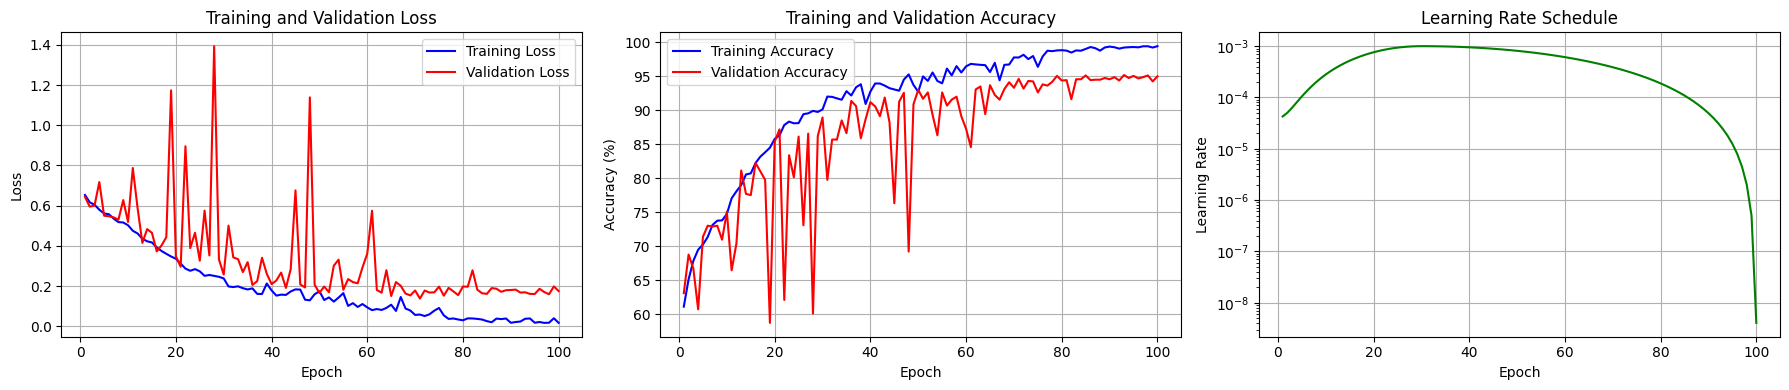


Evaluating on test set...


Evaluating: 100%|██████████| 32/32 [00:01<00:00, 25.25it/s, Acc=95.70%]


TEST RESULTS
Test Loss: 0.1636
Test Accuracy: 95.70%
Correct Predictions: 1936/2023

Classification Report:
              precision    recall  f1-score   support

        cats       0.95      0.96      0.96      1011
        dogs       0.96      0.95      0.96      1012

    accuracy                           0.96      2023
   macro avg       0.96      0.96      0.96      2023
weighted avg       0.96      0.96      0.96      2023



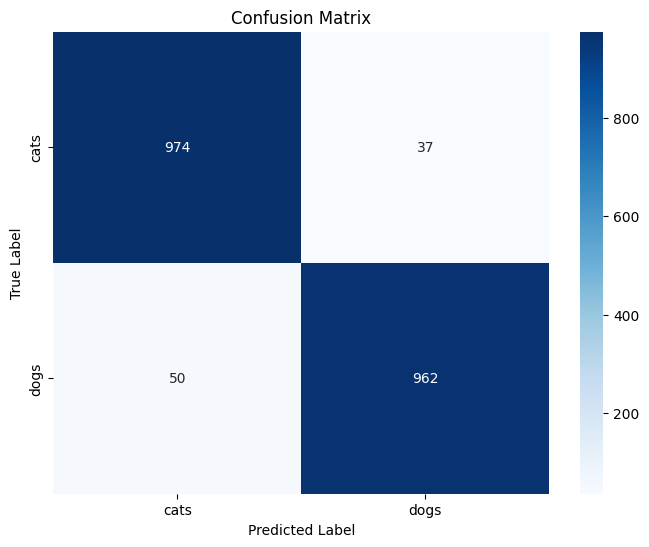

In [13]:
# v2
resize = 112
# Data transformations
train_transform = transforms.Compose([
    # Data Augmentation
    transforms.Resize((resize, resize)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

    # Convert to tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Optimized data loading
def load_datasets(batch_size=64):
    """Optimized data loading for faster training"""
    
    # Load datasets
    train_dataset = ImageFolder(root=TRAIN_PATH, transform=train_transform)
    test_dataset = ImageFolder(root=TEST_PATH, transform=val_transform)
    
    # Split training into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Optimized data loaders
    train_loader = DataLoader(
        train_subset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )
    
    val_loader = DataLoader(
        val_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )
    
    return train_loader, val_loader, test_loader, train_dataset.classes

# Visualize sample images
def visualize_samples(train_loader, classes, num_samples=8):
    """Visualize sample images from the dataset"""
    
    # images shape: [64, 3, 112, 112]
    images, labels = next(iter(train_loader))
    
    # Denormalize images for visualization
    def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return torch.clamp(tensor, 0, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(8, 6))
    
    for idx in range(num_samples):
        img = images[idx].clone()
        img = denormalize(img)
        
        row = idx // 4
        col = idx % 4

        # (C, H, W) -> (H, W, C)
        axes[row, col].imshow(img.permute(1, 2, 0))
        axes[row, col].set_title(f'Class: {classes[labels[idx]]}')
        axes[row, col].axis('off')
    
    plt.suptitle('Sample Images from Dataset')
    plt.tight_layout()
    plt.show()

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    """Complete training function"""
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )

    # Automatic Mixed Precision
    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'learning_rates': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    early_stop_patience = 30
    total_training_time = 0.0
    
    print("Starting training...")
    print("=" * 80)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    output = model(data)
                    loss = criterion(output, target)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            
            scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for data, target in val_pbar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
                
                val_pbar.set_postfix({
                    'Loss': f'{criterion(output, target).item():.4f}',
                    'Acc': f'{100.*correct_val/total_val:.2f}%'
                })
        
        val_loss /= len(val_loader)
        val_acc = 100. * correct_val / total_val
        
        current_lr = scheduler.get_last_lr()[0]
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)
        
        # Print epoch results
        epoch_time = time.time() - epoch_start_time
        total_training_time += epoch_time
        print(f"\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        print("-" * 60)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history
            }, 'best_catdog_model.pth')
            patience_counter = 0
            print(f"New best validation accuracy: {best_val_acc:.2f}% - Model saved!")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"Early stopping triggered after {early_stop_patience} epochs without improvement")
            break
    
    print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%, total cost time: {total_training_time:.2f}")
    return history

def evaluate_model(model, test_loader, classes):
    """Comprehensive model evaluation"""
    model.eval()
    
    predictions = []
    true_labels = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc='Evaluating')
        for data, target in test_pbar:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
            
            test_pbar.set_postfix({
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    print("=" * 60)
    print("TEST RESULTS")
    print("=" * 60)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Correct Predictions: {correct}/{total}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=classes))
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return test_accuracy, predictions, true_labels

def plot_training_history(history):
    """Plot training curves"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    
    # Loss curves
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    # Learning rate
    ax3.plot(epochs, history['learning_rates'], 'g-')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# Load data and create model
print("Loading datasets...")
train_loader, val_loader, test_loader, classes = load_datasets(batch_size=64)
print(f"Classes: {classes}")

# Visualize sample data
visualize_samples(train_loader, classes)

# Create model
model = CatDogCNN(num_classes=len(classes)).to(device)

# Train model
print("\nStarting model training...")
history = train_model(model, train_loader, val_loader, num_epochs=100)

# Plot training history
plot_training_history(history)

# Evaluate on test set
print("\nEvaluating on test set...")
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, classes)

Model loaded successfully from best_catdog_model.pth

Prediction for image: cat1.jpg
Predicted Class: CAT
Confidence: 100.00%


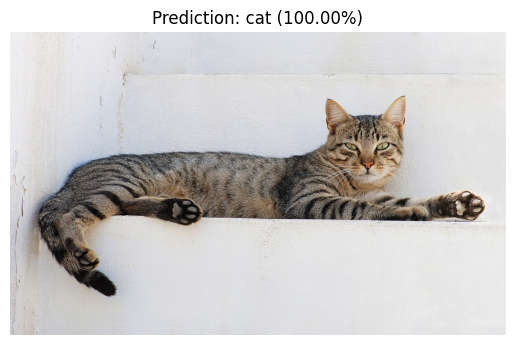

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, transform, classes, device):
    """
    Predicts the class for a single image.

    Args:
        model (nn.Module): The trained PyTorch model.
        image_path (str): The path to the image file.
        transform (transforms.Compose): The transformations to apply to the image.
        classes (list): A list of class names, where the index corresponds to the model's output.
        device (torch.device): The device to run the prediction on (e.g., 'cuda' or 'cpu').

    Returns:
        tuple: A tuple containing the predicted class name (str) and the confidence (float), or (None, None) on error.
    """
    # 1. Set the model to evaluation mode.
    #    This disables training-specific behaviors like Dropout and sets BatchNorm to use running stats.
    model.eval()

    # 2. Load and preprocess the image.
    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None
        
    # Apply the exact same transformations as used for the validation/test set.
    image_tensor = transform(image)

    # 3. Add a batch dimension.
    #    The model expects an input of shape (B, C, H, W), where B is the batch size.
    #    Currently, image_tensor has the shape (C, H, W).
    #    We need to change it to (1, C, H, W).
    image_tensor = image_tensor.unsqueeze(0)

    # 4. Move the data to the correct device.
    image_tensor = image_tensor.to(device)

    # 5. Execute the prediction within a no_grad context for efficiency.
    with torch.no_grad():
        output = model(image_tensor)

    # 6. Interpret the results.
    #    'output' contains the raw model outputs (logits), with shape [1, num_classes].
    #    Use softmax to convert logits to probabilities.
    probabilities = F.softmax(output, dim=1)
    
    # Get the highest probability as the confidence score and its index.
    confidence, predicted_idx = torch.max(probabilities, 1)
    
    # Convert the index to a class name.
    predicted_class = classes[predicted_idx.item()]
    
    return predicted_class, confidence.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['cat', 'dog'] 

# Load your trained model.
# model = CatDogCNN(num_classes=len(classes)).to(device)

# Load the saved weights.
model_path = 'best_catdog_model.pth'
try:
    # Load the entire checkpoint.
    checkpoint = torch.load(model_path, map_location=device, weights_only=False) 
    
    # Load the model's state dictionary from the checkpoint.
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded successfully from {model_path}")

except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}. Please check the path.")
    exit() # Exit if the model file does not exist.
except NameError:
    print("Error: The 'model' variable is not defined. Make sure to instantiate your model (e.g., CatDogCNN) first.")
    exit()

# Define the exact same image transformations as used for the validation set.
resize = 112
val_transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Specify the path to the image you want to predict.
image_to_predict = 'cat1.jpg'
# image_to_predict = 'duck2.jpg'

# Call the prediction function.
predicted_class, confidence = predict_single_image(model, image_to_predict, val_transform, classes, device)

if predicted_class is not None:
    print(f"\nPrediction for image: {image_to_predict}")
    print(f"Predicted Class: {predicted_class.upper()}")
    print(f"Confidence: {confidence * 100:.2f}%")

    try:
        img = Image.open(image_to_predict)
        plt.imshow(img)
        plt.title(f'Prediction: {predicted_class} ({confidence * 100:.2f}%)')
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        pass